In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os

from data_preprocessing import *
from models import SimpleCNN, ResNet
from models.utils import TestCallback
from cutout.cutout import DynamicCutoutLayer, RandomCutoutLayer
from cutout.utils import zero_out, zero_out_batched
# from cutout.mult_cutout import CutOut

2024-04-14 13:31:20.599792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'],
                                          as_supervised=True, with_info=True,
                                          shuffle_files=True)

INFO:absl:Load dataset info from /home/martin/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/martin/tensorflow_datasets/cifar10/3.0.2)
2024-04-14 13:31:22.530936: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from /home/martin/tensorflow_datasets/cifar10/3.0.2


In [4]:
label_names = info_ds.features['label'].names
print(label_names)
# tfds.show_examples(train_ds, info_ds, rows=1, cols=4)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='square')

train_data = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="train", cutout_layer=rnd_cutout))
val_data = train_ds.take(10000).apply(lambda ds:
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="val"))
test_data = test_ds.apply(lambda ds:
                          prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="test"))

2024-04-14 13:31:23.419337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 13:31:23.419963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 13:31:24.706016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

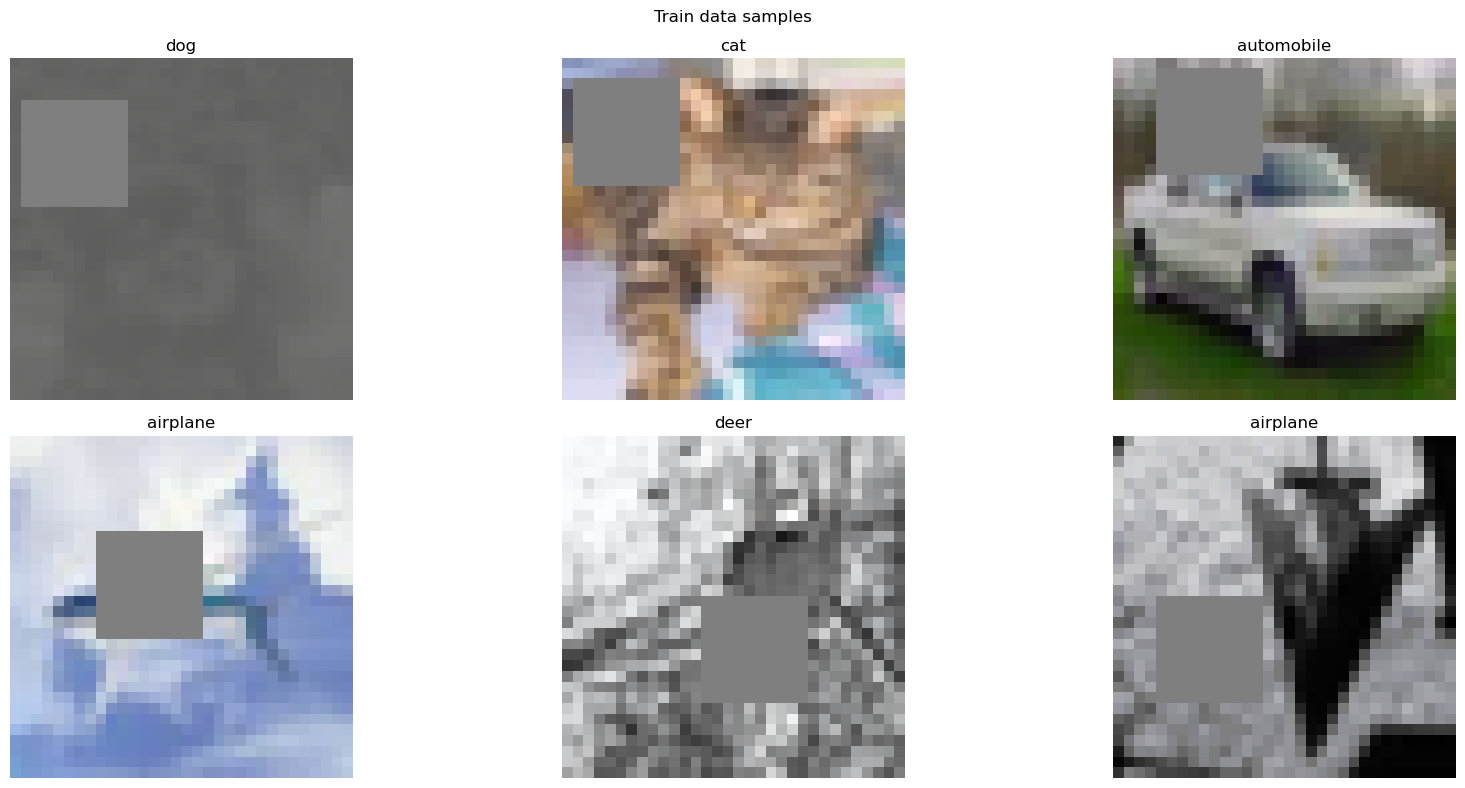

2024-04-14 13:31:25.018883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 13:31:25.019349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


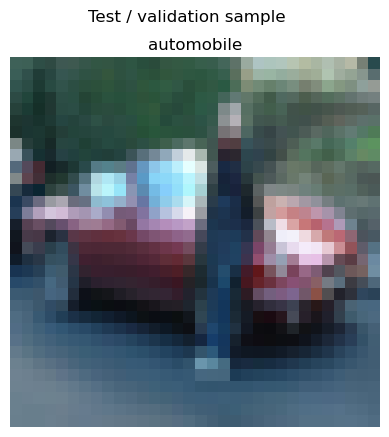

In [6]:
import matplotlib.pyplot as plt

# samples from train data
num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(train_data.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    label = label_names[np.argmax(label[0])]
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
# image from test data
img_test, label_test = iter(test_data.take(1)).next()
plt.imshow((img_test[0] + 1) / 2)
plt.suptitle('Test / validation sample')
plt.title(f"{label_names[np.argmax(label_test[0])]}")
plt.axis('off')
plt.show()

In [9]:
simple_CNN = SimpleCNN()
simple_CNN.build((None, 32, 32, 3))  # Necessary to create the model's weights
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

res_net18 = ResNet((32, 32, 3), 10, type='resnet18')
res_net18.build((None, 32, 32, 3))
res_net18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net18.summary()

res_net34 = ResNet((32, 32, 3), 10, type='resnet34')
res_net34.build((None, 32, 32, 3))
res_net34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net34.summary()

In [10]:
# test with less data
train_split = train_data.take(10)
val_split = val_data.take(1)
test_split = test_data.take(10)
## -----------------------------------------------------------
test_res_callback_sCNN = TestCallback(test_data=test_split)
test_res_callback_res18 = TestCallback(test_data=test_split)
test_res_callback_res34 = TestCallback(test_data=test_split)

history_sCNN = simple_CNN.fit(train_split, epochs=2, validation_data=val_split, callbacks=[test_res_callback_sCNN])
history_res18 = res_net18.fit(train_split, epochs=2, validation_data=val_split, callbacks=[test_res_callback_res18])
history_res34 = res_net34.fit(train_split, epochs=2, validation_data=val_split, callbacks=[test_res_callback_res34])

# Ensure the directory exists and save the model weights
os.makedirs('trained_models', exist_ok=True)
simple_CNN.save_weights('trained_models/simpleCNN.h5')
res_net18.save_weights('trained_models/resnet18.h5')
res_net34.save_weights('trained_models/resnet34.h5')

Epoch 1/2


2024-04-14 13:33:01.369432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 13:33:01.370189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


10/10 [==============================] - ETA: 0s - loss: 2.2747 - accuracy: 0.1352

2024-04-14 13:33:03.945689: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 13:33:04.068370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 13:33:04.069251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

Epoch 0: Testing loss: 2.152203321456909, accuracy: 0.21953125298023224
10/10 [==============================] - 4s 240ms/step - loss: 2.2747 - accuracy: 0.1352 - val_loss: 2.1357 - val_accuracy: 0.2344 - epoch: 0.0000e+00 - test_loss: 2.1522 - test_accuracy: 0.2195
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 2.1754 - accuracy: 0.2148

2024-04-14 13:33:07.336060: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 13:33:07.820572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.0210137367248535, accuracy: 0.2734375
10/10 [==============================] - 3s 208ms/step - loss: 2.1754 - accuracy: 0.2148 - val_loss: 2.0396 - val_accuracy: 0.2656 - epoch: 1.0000 - test_loss: 2.0210 - test_accuracy: 0.2734
Epoch 1/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.5516 - accuracy: 0.1849

2024-04-14 13:33:16.816339: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.5209 - accuracy: 0.1906

2024-04-14 13:33:18.012892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.2747156620025635, accuracy: 0.20937499403953552
10/10 [==============================] - 11s 773ms/step - loss: 2.5209 - accuracy: 0.1906 - val_loss: 2.2772 - val_accuracy: 0.2109 - epoch: 0.0000e+00 - test_loss: 2.2747 - test_accuracy: 0.2094
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.1437 - accuracy: 0.2517

2024-04-14 13:33:25.472190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.1467 - accuracy: 0.2516

2024-04-14 13:33:26.375416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.2042434215545654, accuracy: 0.22734375298023224
10/10 [==============================] - 8s 720ms/step - loss: 2.1467 - accuracy: 0.2516 - val_loss: 2.1803 - val_accuracy: 0.2344 - epoch: 1.0000 - test_loss: 2.2042 - test_accuracy: 0.2273
Epoch 1/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.6469 - accuracy: 0.1467

2024-04-14 13:33:46.575114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.6155 - accuracy: 0.1398

2024-04-14 13:33:48.314896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.300269603729248, accuracy: 0.07265625149011612
10/10 [==============================] - 18s 1s/step - loss: 2.6155 - accuracy: 0.1398 - val_loss: 2.3009 - val_accuracy: 0.0781 - epoch: 0.0000e+00 - test_loss: 2.3003 - test_accuracy: 0.0727
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.2148 - accuracy: 0.2066

2024-04-14 13:33:59.776795: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.2088 - accuracy: 0.2023

2024-04-14 13:34:01.171199: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.3046555519104004, accuracy: 0.140625
10/10 [==============================] - 13s 1s/step - loss: 2.2088 - accuracy: 0.2023 - val_loss: 2.3206 - val_accuracy: 0.1172 - epoch: 1.0000 - test_loss: 2.3047 - test_accuracy: 0.1406


In [11]:
print(history_sCNN.params, history_sCNN.history.keys())
print(history_sCNN.history['val_accuracy'])

print(history_res18.params, history_res18.history.keys())
print(history_res18.history['val_accuracy'])

print(history_res34.params, history_res34.history.keys())
print(history_res34.history['val_accuracy'])

{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.234375, 0.265625]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.2109375, 0.234375]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.078125, 0.1171875]


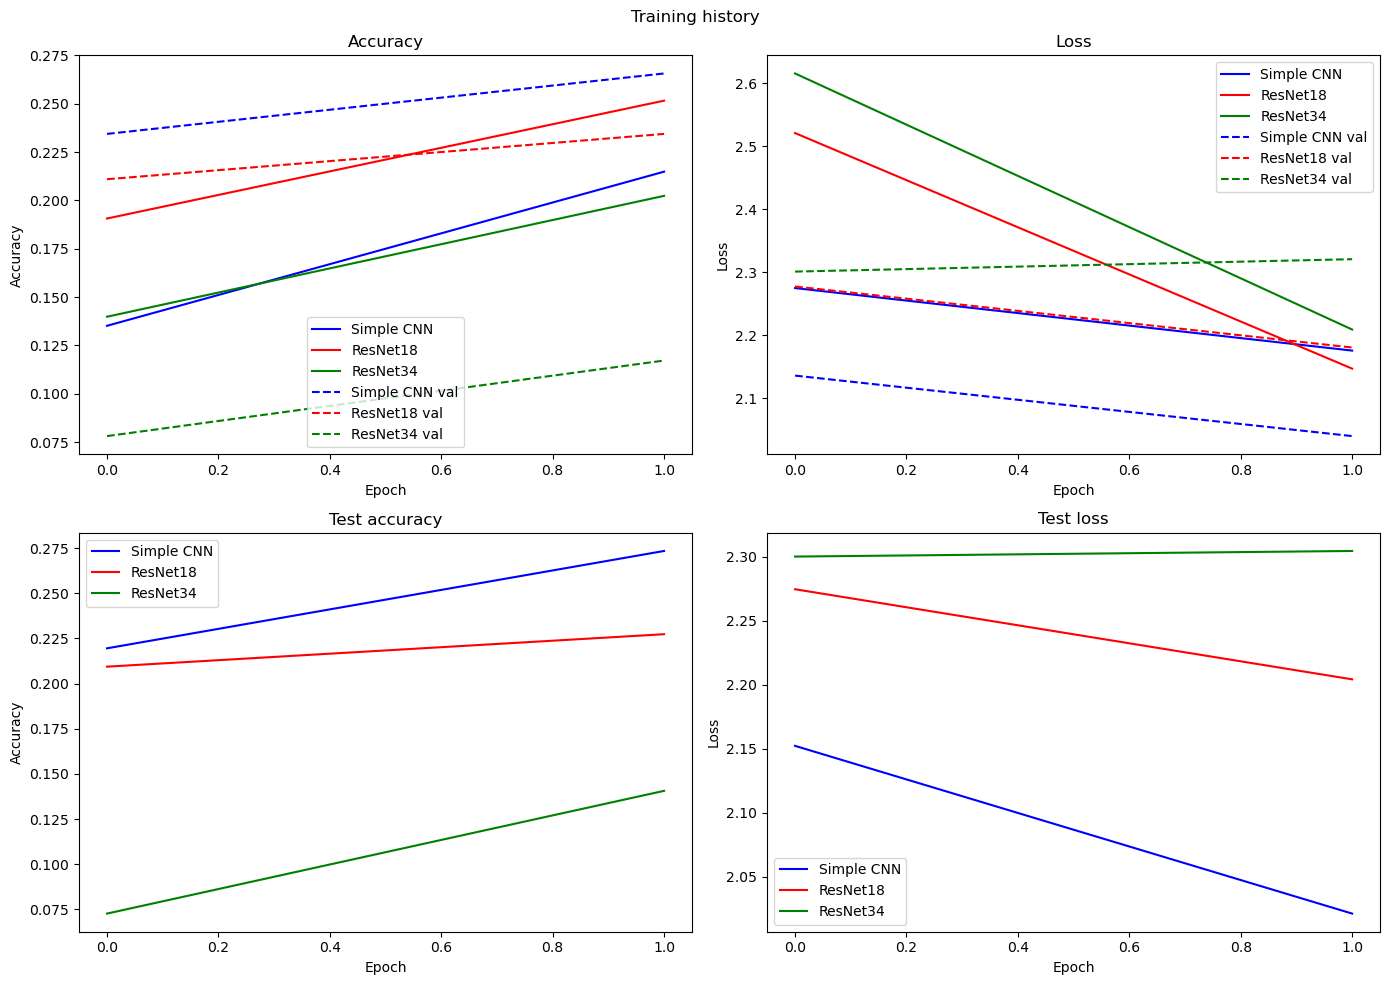

In [12]:
# plot the training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training history')
# accuracy
axes[0,0].plot(history_sCNN.history['accuracy'], label='Simple CNN', color='b')
axes[0,0].plot(history_res18.history['accuracy'], label='ResNet18', color='r')
axes[0,0].plot(history_res34.history['accuracy'], label='ResNet34', color='g')
axes[0,0].plot(history_sCNN.history['val_accuracy'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,0].plot(history_res18.history['val_accuracy'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,0].plot(history_res34.history['val_accuracy'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,0].set_title('Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()

# loss 
axes[0,1].plot(history_sCNN.history['loss'], label='Simple CNN', color='b')
axes[0,1].plot(history_res18.history['loss'], label='ResNet18', color='r')
axes[0,1].plot(history_res34.history['loss'], label='ResNet34', color='g')
axes[0,1].plot(history_sCNN.history['val_loss'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,1].plot(history_res18.history['val_loss'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,1].plot(history_res34.history['val_loss'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,1].set_title('Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()

# test accuracy
axes[1,0].plot(test_res_callback_sCNN.test_results['test_accuracy'], label='Simple CNN', color='b')
axes[1,0].plot(test_res_callback_res18.test_results['test_accuracy'], label='ResNet18', color='r')
axes[1,0].plot(test_res_callback_res34.test_results['test_accuracy'], label='ResNet34', color='g')
axes[1,0].set_title('Test accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()

# test loss
axes[1,1].plot(test_res_callback_sCNN.test_results['test_loss'], label='Simple CNN', color='b')
axes[1,1].plot(test_res_callback_res18.test_results['test_loss'], label='ResNet18', color='r')
axes[1,1].plot(test_res_callback_res34.test_results['test_loss'], label='ResNet34', color='g')
axes[1,1].set_title('Test loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()

plt.tight_layout()
plt.show()


2024-04-14 13:34:12.037781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 13:34:12.038330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - 0s 31ms/step


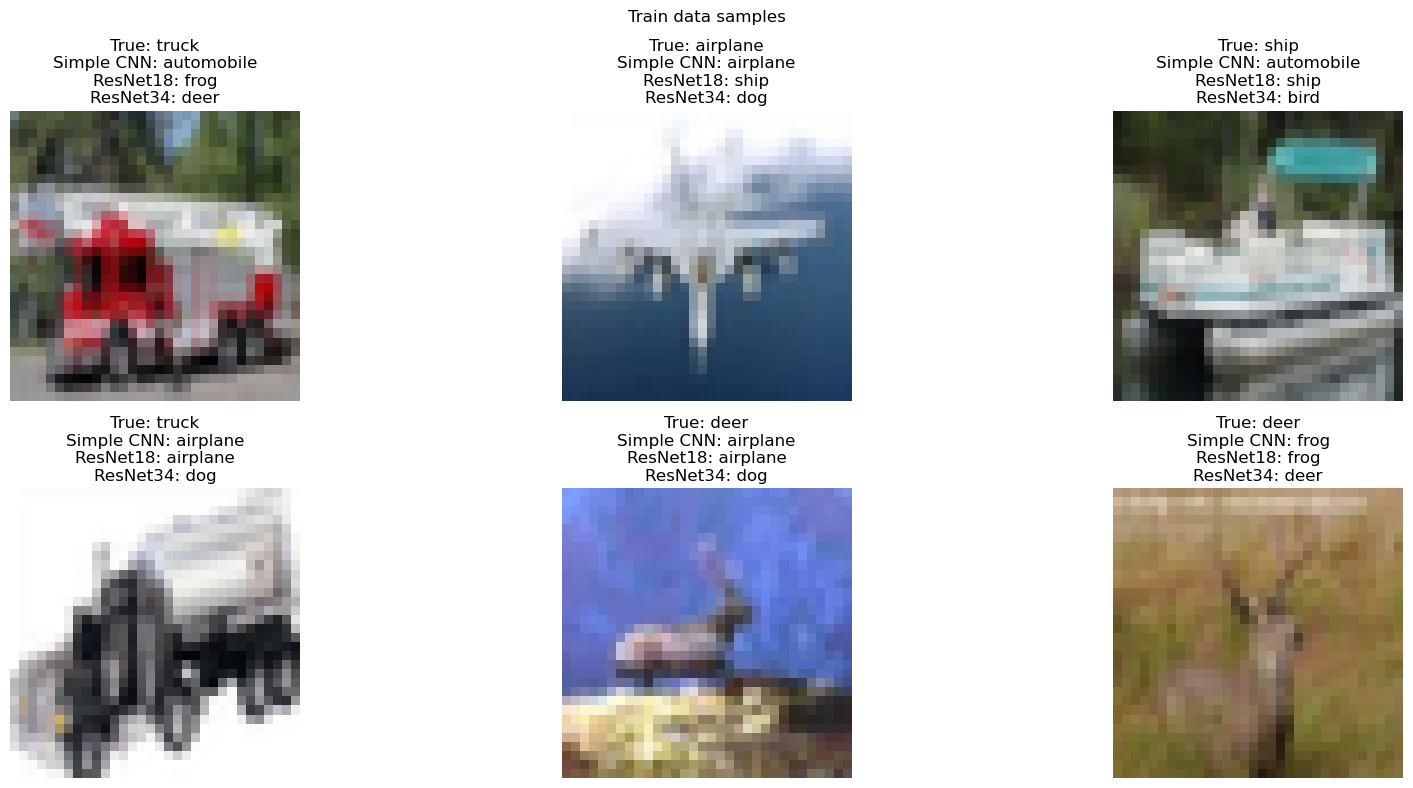

In [13]:
# Make a prediction with some test samples
# simple_CNN.load_weights('trained_models/simpleCNN.h5')
# res_net18.load_weights('trained_models/resnet18.h5')
# res_net34.load_weights('trained_models/resnet34.h5')

num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(test_data.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    pred_sCNN = simple_CNN.predict(image)
    pred_res18 = res_net18.predict(image)
    pred_res34 = res_net34.predict(image)
    true_label = label_names[np.argmax(label[0])]
    pred_label_sCNN = label_names[np.argmax(pred_sCNN[0])]
    pred_label_res18 = label_names[np.argmax(pred_res18[0])]
    pred_label_res34 = label_names[np.argmax(pred_res34[0])]
    label = f"True: {true_label}\nSimple CNN: {pred_label_sCNN}\nResNet18: {pred_label_res18}\nResNet34: {pred_label_res34}"
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()